# Milestone Report Part 1: Problem Defination and Data Preprocessing

## Problem Description

### Project Task

The capstone 2 project comes from the kaggle competition "Data Science Bowl 2017" at the following link: https://www.kaggle.com/c/data-science-bowl-2017. The challenge for this year is detecting lung tumor. More specifically, "Participants will develop algorithms that accurately determine when lesions in the lungs are cancerous, using a data set of thousands of high-resolution lung scans provided by the National Cancer Institute."

Given the above description, it is clear that for this project, the objective is:

* Build a model that will detect whether a lung cancer occured.

### Potential Client

According to the project description, 

"This will dramatically reduce the false positive rate that plagues the current detection technology, get patients earlier access to life-saving interventions, and give radiologists more time to spend with their patients."

Because of that, potential clients for this project could be hospitals and health/cancer department of the goverments.

## Data Summary and Loading

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import skimage, os
from skimage.morphology import ball, disk, dilation, binary_erosion, remove_small_objects, erosion, closing, reconstruction, binary_closing
from skimage.measure import label,regionprops, perimeter
from skimage.morphology import binary_dilation, binary_opening
from skimage.filters import roberts, sobel
from skimage import measure, feature
from skimage.segmentation import clear_border
from skimage import data
from scipy import ndimage as ndi

%matplotlib inline

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import dicom
import scipy.misc
import numpy as np

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output
print(check_output(["ls", "../../cap2input"]).decode("utf8"))

output
sample_images
stage1
stage1_labels.csv
stage1_sample_submission.csv
stage1_solution.csv
stage2
stage2.7z
stage2_sample_submission.csv.zip
stage2_solution.csv



In [2]:
print(check_output(["ls", "../../cap2input/sample_images/"]).decode("utf8"))

00cba091fa4ad62cc3200a657aeb957e
0a099f2549429d29b32f349e95fb2244
0a0c32c9e08cc2ea76a71649de56be6d
0a38e7597ca26f9374f8ea2770ba870d
0acbebb8d463b4b9ca88cf38431aac69
0b20184e0cd497028bdd155d9fb42dc9
0bd0e3056cbf23a1cb7f0f0b18446068
0c0de3749d4fe175b7a5098b060982a1
0c37613214faddf8701ca41e6d43f56e
0c59313f52304e25d5a7dcf9877633b1
0c60f4b87afcb3e2dfa65abbbf3ef2f9
0c98fcb55e3f36d0c2b6507f62f4c5f1
0c9d8314f9c69840e25febabb1229fa4
0ca943d821204ceb089510f836a367fd
0d06d764d3c07572074d468b4cff954f
0d19f1c627df49eb223771c28548350e
0d2fcf787026fece4e57be167d079383
0d941a3ad6c889ac451caf89c46cb92a
0ddeb08e9c97227853422bd71a2a695e
0de72529c30fe642bc60dcb75c87f6bd



Each CT Scan consists of multiple 2D slices which are provided in a DICOM format. At first, I will read the random dicom file of a CT Scan. After reading the image file, we will update the intensity values lower than -1900 with the corresponding value of air, because they are the pixels that fall outside of the scanner bounds, and normally it would be air.

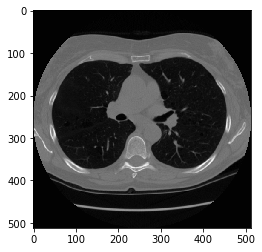

In [3]:
# Any results you write to the current directory are saved as output.
lung = dicom.read_file('../../cap2input/sample_images/00cba091fa4ad62cc3200a657aeb957e/38c4ff5d36b5a6b6dc025435d62a143d.dcm')

slice = lung.pixel_array
intercept = int(lung.RescaleIntercept)
slice[slice <= -1900] = -1000-intercept # assume the regions outside scanning area is air
plt.imshow(slice, cmap=plt.cm.gray)

Ok looking good. Now let us put them into one function so that we can use them. Note that I convert everything into Hounsfield scale using the RescaleIntercept and RescaleSlope from the dicom files.

In [4]:
def read_ct_scan(folder_name):
        # Read the slices from the dicom file
        slices = [dicom.read_file(folder_name + filename) for filename in os.listdir(folder_name)]
        
        # Sort the dicom slices in their respective order
        slices.sort(key=lambda x: int(x.InstanceNumber))
        
        # Get the pixel values for all the slices
        image = np.stack([s.pixel_array for s in slices])
        intercept = int(slices[0].RescaleIntercept)
        image[image <= -1900] = -1000-intercept
        
        for slice_number in range(len(slices)):
        
            intercept = slices[slice_number].RescaleIntercept
            slope = slices[slice_number].RescaleSlope
            
            #print(intercept,slope)
        
            if slope != 1:
                image[slice_number] = slope * image[slice_number].astype(np.float64)
            image[slice_number] = image[slice_number].astype(np.int16)
            intercept = np.int16(intercept)
            image[slice_number] += intercept.astype(image[slice_number].dtype)
    
        return np.array(image, dtype=np.int16)

these are just a few examples for evaluation of the algorithm. You can uncomment any read command to see how the method performs. 

In [5]:
#ct_scan = read_ct_scan('../../cap2input/sample_images/00cba091fa4ad62cc3200a657aeb957e/') # not tumor
ct_scan = read_ct_scan('../../cap2input/stage1/0015ceb851d7251b8f399e39779d1e7d/') # tumor
#ct_scan = read_ct_scan('../../cap2input/stage1/006b96310a37b36cccb2ab48d10b49a3/') # tumor
#ct_scan = read_ct_scan('../../cap2input/stage1/ea7373271a2441b5864df2053c0f5c3e/') # tumor
#ct_scan = read_ct_scan('../../cap2input/stage2/03990e71d5a98502e4e7f63f8203d760/') # tumor
#ct_scan = read_ct_scan('../../cap2input/stage1/3457880b1a66030feb8adaed6da805af/')

To visualise the slices, we will have to plot them. `matplotlib` is used for plotting the slices. The `plot_ct_scan` function takes a 3D CT Scanned Image array  as input and plots equally spaced slices. The CT Scans are grayscale images i.e. the value of each pixel is a single sample, which means it carries only intensity information.

In [6]:
def plot_ct_scan(scan):
    f, plots = plt.subplots(int(scan.shape[0] / 20) + 1, 4, figsize=(25, 25))
    for i in range(0, scan.shape[0], 5):
        plots[int(i / 20), int((i % 20) / 5)].axis('off')
        plots[int(i / 20), int((i % 20) / 5)].imshow(scan[i], cmap=plt.cm.bone)

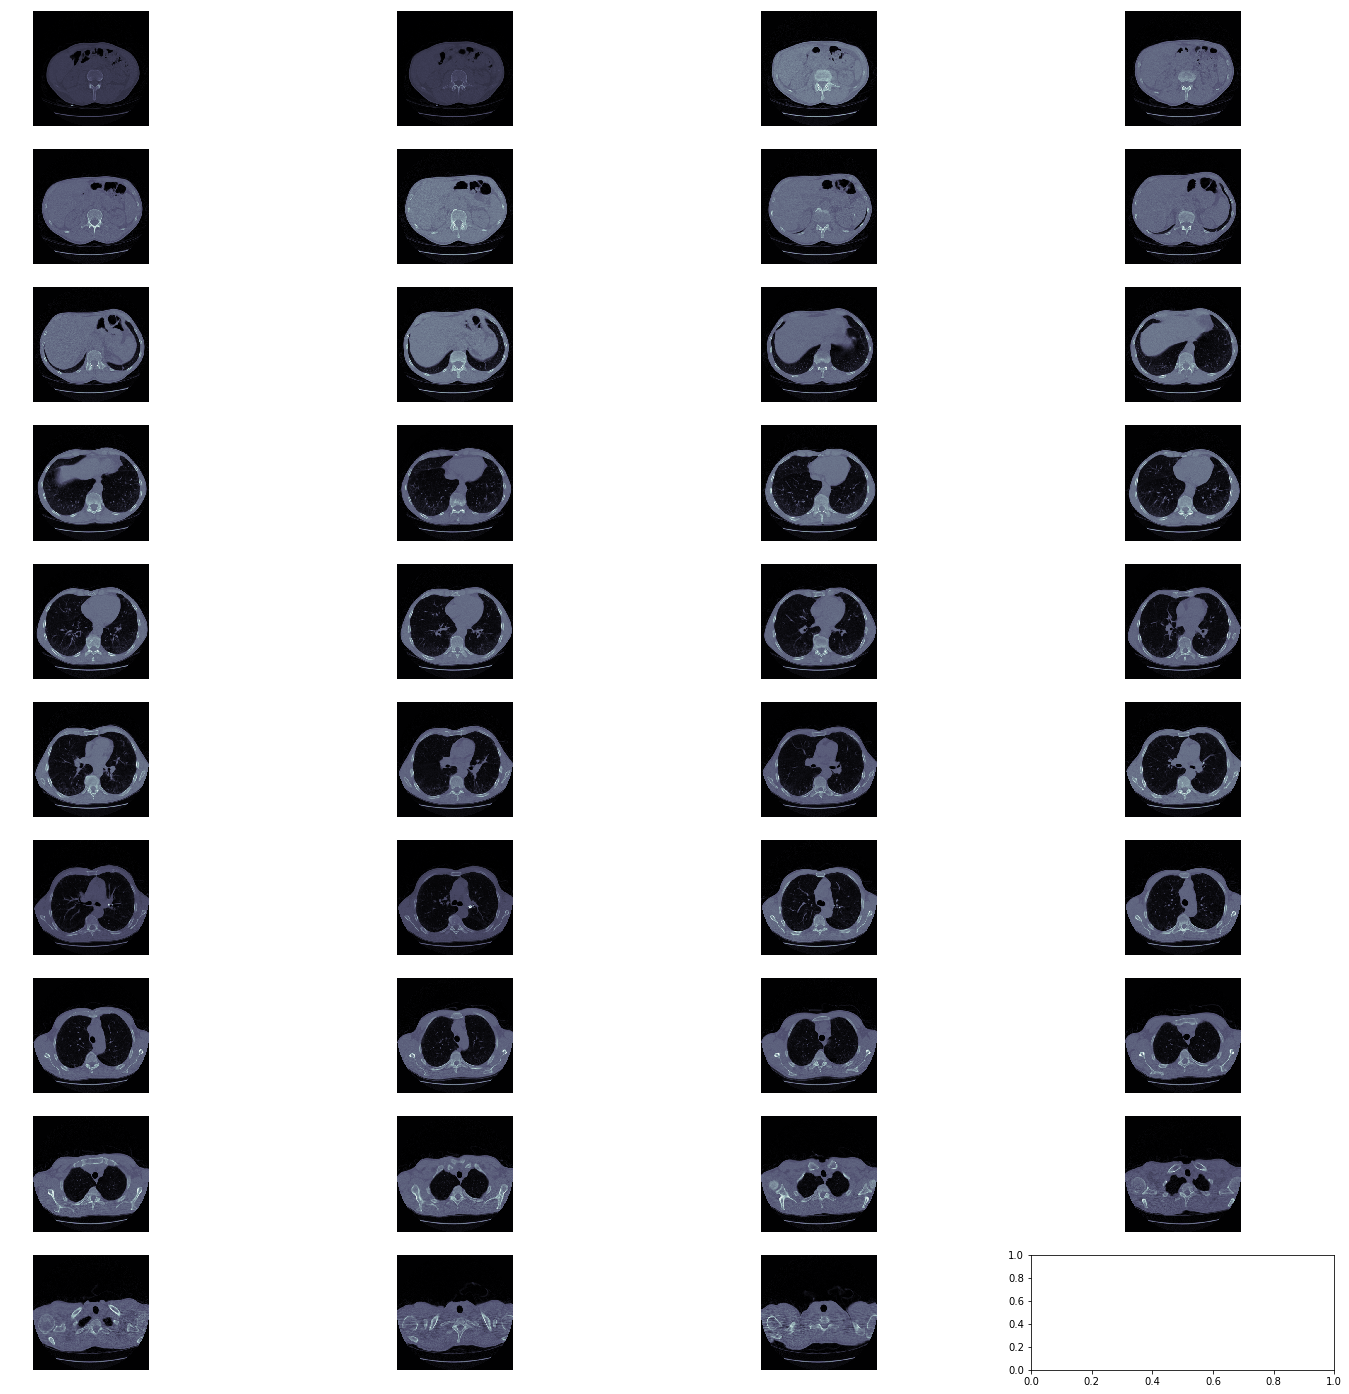

In [7]:
plot_ct_scan(ct_scan)

## Segmentation of Lungs ##
After reading the CT Scan, the first step in preprocessing is the segmentation of lung structures because it is obvious that the regions of interests lies inside the lungs. It is visible that the lungs are the darker regions in the CT Scans. The bright region inside the lungs are the blood vessels or air. A threshold of -400 HU is used at all places because it was found in experiments that it works just fine. We segment lung structures from each slice of the CT Scan image and try not to loose the possible region of interests attached to the lung wall. There are some nodules which may be attached to the lung wall.

This method is inspired by the kaggle notebook here: https://www.kaggle.com/arnavkj95/candidate-generation-and-luna16-preprocessing. I change a few parameters and steps to simplify processing stages in order to save time. 

I also move the paper list from the notebook here for my own reference.

In [8]:
#thres = 604
THRES = -400

def get_segmented_lungs(im, plot=False):
    '''
    This funtion segments the lungs from the given 2D slice.
    '''
    if plot == True:
        f, plots = plt.subplots(8, 1, figsize=(5, 40))
    '''
    Step 1: Convert into a binary image. 
    '''
    binary = im < THRES
    if plot == True:
        plots[0].axis('off')
        plots[0].imshow(binary, cmap=plt.cm.bone) 
    '''
    Step 2: Remove the blobs connected to the border of the image.
    '''
    cleared = clear_border(binary)
    if plot == True:
        plots[1].axis('off')
        plots[1].imshow(cleared, cmap=plt.cm.bone) 
    '''
    Step 3: Label the image.
    '''
    label_image = label(cleared)
    if plot == True:
        plots[2].axis('off')
        plots[2].imshow(label_image, cmap=plt.cm.bone) 
    '''
    Step 4: Keep the labels with 2 largest areas.(right lung and left lung)
    '''
    areas = [r.area for r in regionprops(label_image)]
    areas.sort()
    if len(areas) > 2:
        for region in regionprops(label_image):
            if region.area < areas[-2]:
                for coordinates in region.coords:                
                       label_image[coordinates[0], coordinates[1]] = 0
    binary = label_image > 0
    if plot == True:
        plots[3].axis('off')
        plots[3].imshow(binary, cmap=plt.cm.bone) 
    '''
    Step 5: Erosion operation with a disk of radius 2. This operation is 
    seperate the lung nodules attached to the blood vessels.
    '''
    selem = disk(2)
    binary = binary_erosion(binary, selem)
    if plot == True:
        plots[4].axis('off')
        plots[4].imshow(binary, cmap=plt.cm.bone) 
    '''
    Step 6: Closure operation with a disk of radius 10. This operation is 
    to keep nodules attached to the lung wall.
    '''
    selem = disk(12)
    binary = binary_closing(binary, selem)
    if plot == True:
        plots[5].axis('off')
        plots[5].imshow(binary, cmap=plt.cm.bone) 
    '''
    Step 7: Fill in the small holes inside the binary mask of lungs.
    '''
    edges = roberts(binary)
    binary = ndi.binary_fill_holes(edges)
    if plot == True:
        plots[6].axis('off')
        plots[6].imshow(binary, cmap=plt.cm.bone) 
    '''
    Step 8: Superimpose the binary mask on the input image.
    '''
    get_high_vals = binary == 0
    im[get_high_vals] = -1000
    if plot == True:
        plots[7].axis('off')
        plots[7].imshow(im, cmap=plt.cm.bone) 
        
    return im

The `get_segmented_lungs` function segments a 2D slice of the CT Scan. I have outputted the slice after all steps for better visualisation and understanding of the code and applied operations.

array([[-1000, -1000, -1000, ..., -1000, -1000, -1000],
       [-1000, -1000, -1000, ..., -1000, -1000, -1000],
       [-1000, -1000, -1000, ..., -1000, -1000, -1000],
       ..., 
       [-1000, -1000, -1000, ..., -1000, -1000, -1000],
       [-1000, -1000, -1000, ..., -1000, -1000, -1000],
       [-1000, -1000, -1000, ..., -1000, -1000, -1000]], dtype=int16)

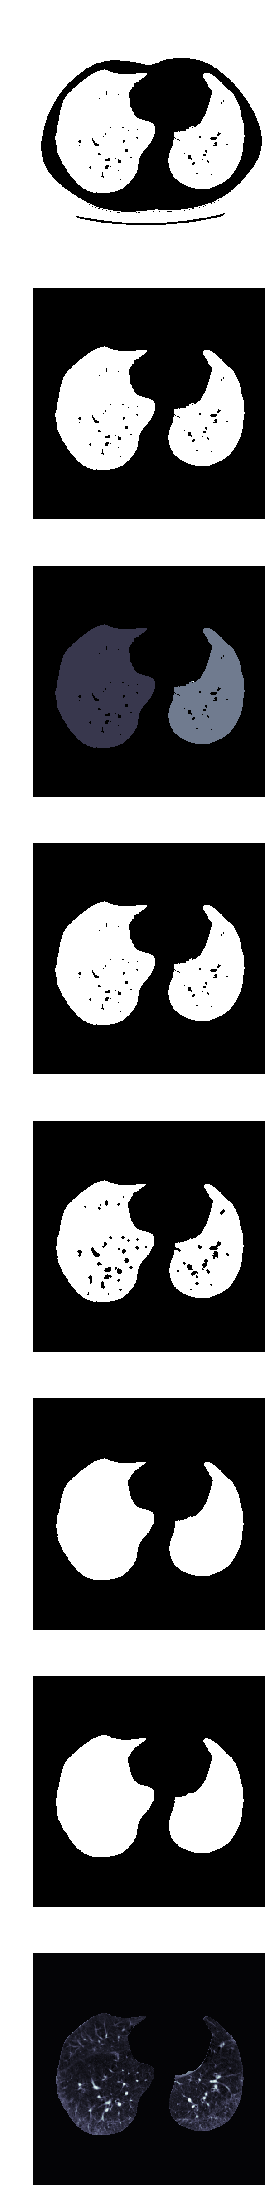

In [9]:
get_segmented_lungs(ct_scan[73], True)

Now, I will segment the whole CT Scan slice by slice and show some slices of the CT Scan.

In [10]:
def segment_lung_from_ct_scan(ct_scan):
    return np.asarray([get_segmented_lungs(slice) for slice in ct_scan])

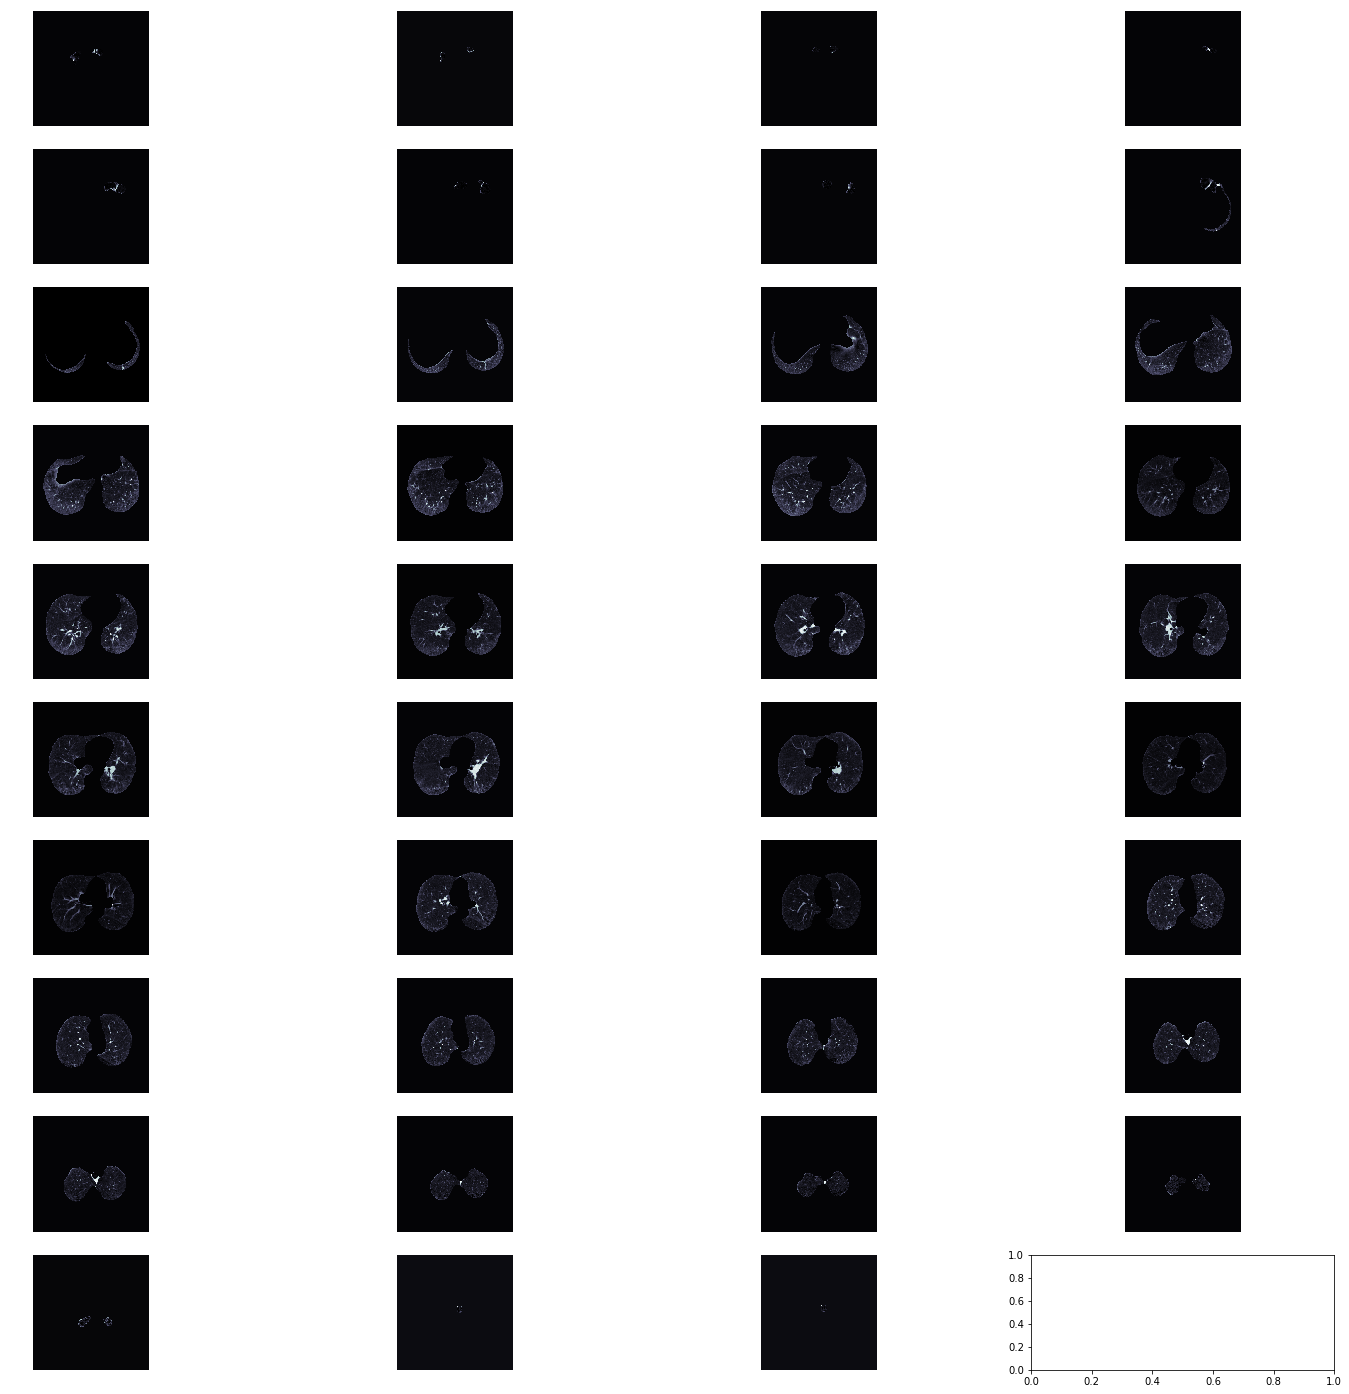

In [11]:
segmented_ct_scan = segment_lung_from_ct_scan(ct_scan)
plot_ct_scan(segmented_ct_scan)

Nodule Candidate/Region of Interest Generation
---------------------------
After segmenting the lung structures from the CT Scanned images, our task is to find the candidate regions with nodules since the search space is very large. Also, whole image can't be classified directly using 3D CNNs due to limit on computation, we need to find possible regions of cancer and then classify them. It was found in experiments that all the region of interests have intensity > -400 HU. So, we used this threshold to filter the darker regions. This reduces the number of candidates by a large number and preserves all the important regions with high recall. We then classify all the candidate points to reduce the False Positives.

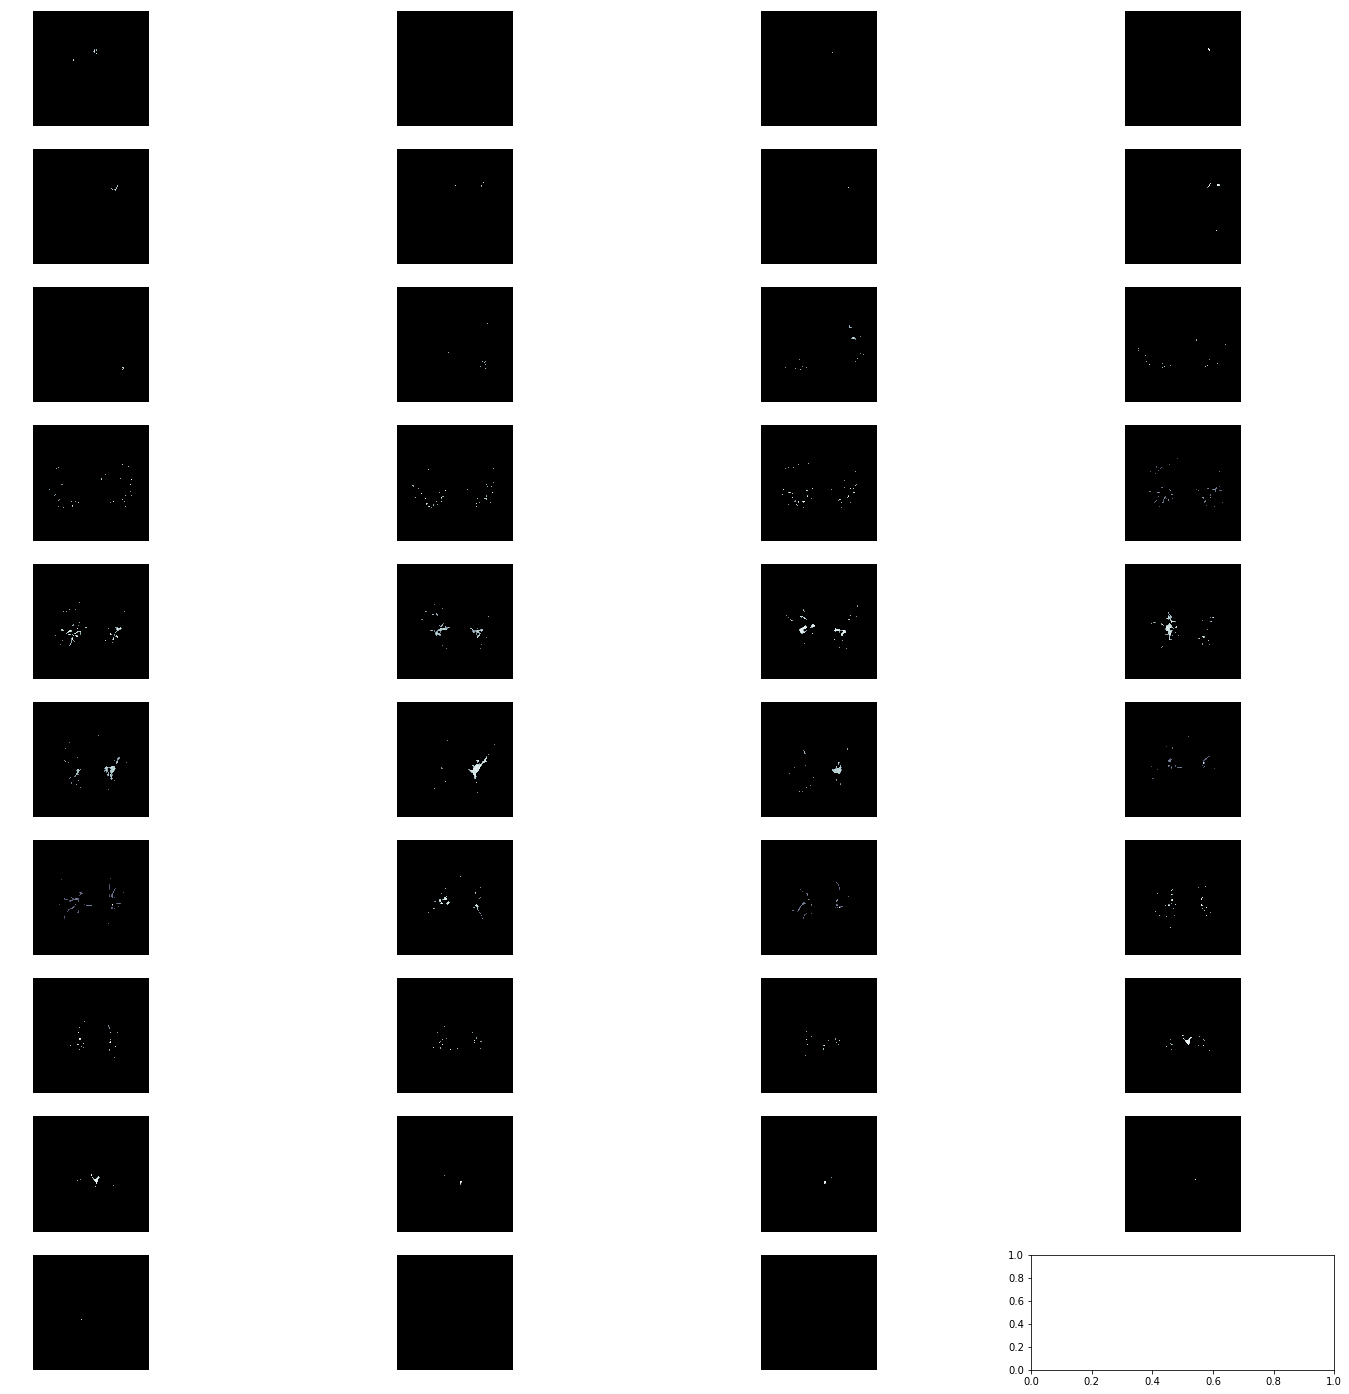

In [12]:
segmented_ct_scan[segmented_ct_scan < THRES] = -1000

plot_ct_scan(segmented_ct_scan)

After filtering, there are still lot of noise because of blood vessels. Different from the original version, I just perform a opening operation to get rid of them

In [13]:
from skimage.morphology import opening

selem = ball(3) #was 2
binary = binary_opening(segmented_ct_scan, selem) # was closing
segmented_ct_scan = opening(segmented_ct_scan, selem)

label_scan = label(binary)

areas = [r.area for r in regionprops(label_scan)]
#areas.sort()
print(sum(areas))
#for r in regionprops(label_scan):
#    max_x, max_y, max_z = 0, 0, 0
#    min_x, min_y, min_z = 1000, 1000, 1000
#    
#    for c in r.coords:
#        max_z = max(c[0], max_z)
#        max_y = max(c[1], max_y)
#        max_x = max(c[2], max_x)
#        
#        min_z = min(c[0], min_z)
#        min_y = min(c[1], min_y)
#        min_x = min(c[2], min_x)
#    if (min_z == max_z or min_y == max_y or min_x == max_x or r.area > areas[-1]):
#        for c in r.coords:
#            segmented_ct_scan[c[0], c[1], c[2]] = 0
#    else:
#        index = (max((max_x - min_x), (max_y - min_y), (max_z - min_z))) / (min((max_x - min_x), (max_y - min_y) , (max_z - min_z)))

51093557


The `plot_3d` function plots the 3D numpy array of CT Scans. 

In [14]:
def plot_3d(image, threshold=-1300):
    
    # Position the scan upright, 
    # so the head of the patient would be at the top facing the camera
    p = image.transpose(2,1,0)
    p = p[:,:,::-1]
    
    verts, faces,_,_ = measure.marching_cubes(p, threshold)

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Fancy indexing: `verts[faces]` to generate a collection of triangles
    mesh = Poly3DCollection(verts[faces], alpha=0.1)
    face_color = [0.5, 0.5, 1]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)

    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])

    plt.show()

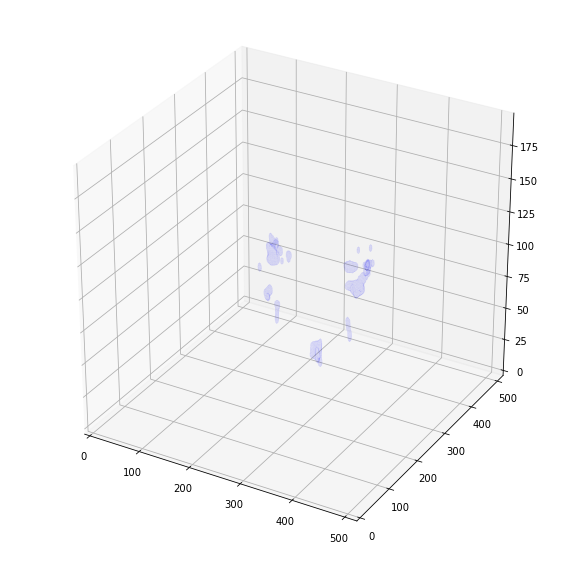

In [15]:
plot_3d(segmented_ct_scan, THRES)

Looking good!